In [1]:
!pip install -q matplotlib
!pip install -q nibabel
!pip install -q pydicom
!pip install numpy 

In [2]:
!python -m pip install --upgrade pip

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load a NIfTI file
nifti_path = r'C:\Users\HP\Downloads\Sample data\sub-68576_ses-2_acq-t1csmp2ragesag06mmUNIDEN_T1w.nii'  # Adjust path as needed
nifti_img = nib.load(nifti_path)

# Extract image data as numpy array
nifti_data = nifti_img.get_fdata()
print("NIfTI image shape:", nifti_data.shape)

NIfTI image shape: (256, 362, 384)


In [4]:
print("Affine matrix:\n", nifti_img.affine)

Affine matrix:
 [[ 6.29829526e-01 -1.45959742e-02  2.20752831e-04 -8.00369873e+01]
 [ 1.45067181e-02  6.17520332e-01  9.53230858e-02 -1.08615631e+02]
 [-2.46380339e-03 -9.52919945e-02  6.17688000e-01 -1.26306412e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
voxel_spacing = tuple(abs(nifti_img.affine[i, i]) for i in range(3))
print("Voxel spacing (mm):", voxel_spacing)


Voxel spacing (mm): (np.float64(0.6298295259475708), np.float64(0.6175203323364258), np.float64(0.617688000202179))


In [6]:
print("Data type:", nifti_img.get_data_dtype())


header = nifti_img.header
print("\nHeader information:")
print(header)

Data type: int16

Header information:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 54
dim             : [  3 256 362 384   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.    0.63  0.625 0.625 6.    0.    0.    0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'TE=2.1;Time=150434.397;phase=1')
aux_file        : np.bytes_(b'Denoised Image (lambda ')
qform_code      : scanner
sform_code      : scanner
quatern_b       

In [7]:
print("\nTR (Repetition Time):", header.get('pixdim')[4])  # If present
print("Dim info:", header.get('dim'))


TR (Repetition Time): 6.0
Dim info: [  3 256 362 384   1   1   1   1]


In [8]:
# Print full shape
print("NIfTI full volume shape:", nifti_data.shape)

# Axial: slicing along Z-axis (top-down view)
axial_shape = nifti_data[:, :, :]
print("Axial view shape:", axial_shape.shape)

# Coronal: slicing along Y-axis (front-back view)
coronal_shape = np.transpose(nifti_data, (0, 2, 1))
print("Coronal view shape:", coronal_shape.shape)

# Sagittal: slicing along X-axis (side-to-side view)
sagittal_shape = np.transpose(nifti_data, (1, 2, 0))
print("Sagittal view shape:", sagittal_shape.shape)

NIfTI full volume shape: (256, 362, 384)
Axial view shape: (256, 362, 384)
Coronal view shape: (256, 384, 362)
Sagittal view shape: (362, 384, 256)


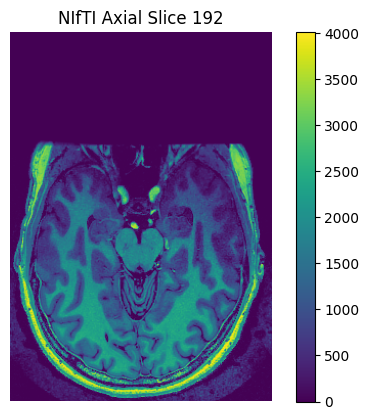

In [9]:
# Visualize the middle axial slice
mid_slice = nifti_data.shape[2] // 2
plt.imshow(np.rot90(nifti_data[:, :, mid_slice]))
plt.title(f'NIfTI Axial Slice {mid_slice}')
plt.axis('off')
plt.colorbar()
plt.show()

In [10]:
import os
import numpy as np
import nibabel as nib
import pydicom
from pydicom.dataset import FileDataset
from datetime import datetime

def save_dicom_slices(volume, affine, output_dir, axis_name):
    os.makedirs(output_dir, exist_ok=True)
    axis = {'axial': 2, 'coronal': 1, 'sagittal': 0}[axis_name]
    num_slices = volume.shape[axis]

    for i in range(num_slices):
        if axis == 0:
            slice_2d = volume[i, :, :]
        elif axis == 1:
            slice_2d = volume[:, i, :]
        elif axis == 2:
            slice_2d = volume[:, :, i]

        # Normalize to 16-bit unsigned integer
        slice_norm = 255 * (slice_2d - np.min(slice_2d)) / (np.max(slice_2d) - np.min(slice_2d) + 1e-5)
        pixel_array = np.uint16(slice_norm)

        # DICOM metadata
        file_meta = pydicom.dataset.FileMetaDataset()
        file_meta.MediaStorageSOPClassUID = pydicom.uid.SecondaryCaptureImageStorage
        file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
        file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
        file_meta.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID

        ds = FileDataset(f'slice_{i}.dcm', {}, file_meta=file_meta, preamble=b"\0" * 128)
        ds.PatientName = "patient"
        ds.PatientID = "918234"
        ds.Modality = "MR"
        ds.StudyInstanceUID = pydicom.uid.generate_uid()
        ds.SeriesInstanceUID = pydicom.uid.generate_uid()
        ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
        ds.SOPClassUID = file_meta.MediaStorageSOPClassUID

        dt = datetime.now()
        ds.ContentDate = dt.strftime('%Y%m%d')
        ds.ContentTime = dt.strftime('%H%M%S')

        ds.Rows, ds.Columns = slice_2d.shape
        ds.SamplesPerPixel = 1
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.BitsAllocated = 16
        ds.BitsStored = 16
        ds.HighBit = 15
        ds.PixelRepresentation = 0
        ds.PixelData = pixel_array.tobytes()

        ds.PixelSpacing = [str(abs(affine[0, 0])), str(abs(affine[1, 1]))]
        ds.SliceThickness = str(abs(affine[2, 2]))

        voxel_coord = [0, 0, 0]
        voxel_coord[axis] = i
        position = affine @ [*voxel_coord, 1]
        ds.ImagePositionPatient = [str(x) for x in position[:3]]

        if axis_name == "axial":
            ds.ImageOrientationPatient = ['1', '0', '0', '0', '1', '0']
        elif axis_name == "coronal":
            ds.ImageOrientationPatient = ['1', '0', '0', '0', '0', '1']
        elif axis_name == "sagittal":
            ds.ImageOrientationPatient = ['0', '1', '0', '0', '0', '1']

        ds.save_as(os.path.join(output_dir, f"{axis_name}_slice_{i:03d}.dcm"))

    print(f"✅ Saved {num_slices} {axis_name} DICOM slices to {output_dir}")


def convert_nifti_to_all_dicom(nifti_path, output_root):
    nii_img = nib.load(nifti_path)
    volume = nii_img.get_fdata()
    affine = nii_img.affine

    save_dicom_slices(volume, affine, os.path.join(output_root, "axial"), "axial")
    save_dicom_slices(volume, affine, os.path.join(output_root, "coronal"), "coronal")
    save_dicom_slices(volume, affine, os.path.join(output_root, "sagittal"), "sagittal")


In [11]:
nifti_path = "sub-68576_ses-2_acq-t1csmp2ragesag06mmUNIDEN_T1w.nii"
output_root = "dicom_output"
convert_nifti_to_all_dicom(nifti_path, output_root)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (18) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (17) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydicom\valuerep.py:440: UserWarning: The value length (19) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
c:\Users\HP\AppD

✅ Saved 384 axial DICOM slices to dicom_output\axial
✅ Saved 362 coronal DICOM slices to dicom_output\coronal
✅ Saved 256 sagittal DICOM slices to dicom_output\sagittal


In [12]:
import pydicom
import os
import numpy as np

def get_dicom_stack_shape(dicom_dir):
    files = sorted([f for f in os.listdir(dicom_dir) if f.endswith(".dcm")])
    if not files:
        print(f"❌ No DICOM files found in {dicom_dir}")
        return None
    
    # Read one slice to get shape
    sample = pydicom.dcmread(os.path.join(dicom_dir, files[0]))
    rows, cols = int(sample.Rows), int(sample.Columns)
    depth = len(files)
    
    return (rows, cols, depth)

# Set the directories
base_dir = "dicom_output"
axial_dir = os.path.join(base_dir, "axial")
coronal_dir = os.path.join(base_dir, "coronal")
sagittal_dir = os.path.join(base_dir, "sagittal")

# Print shapes
axial_shape = get_dicom_stack_shape(axial_dir)
coronal_shape = get_dicom_stack_shape(coronal_dir)
sagittal_shape = get_dicom_stack_shape(sagittal_dir)

print("📏 Axial DICOM stack shape:   ", axial_shape)
print("📏 Coronal DICOM stack shape: ", coronal_shape)
print("📏 Sagittal DICOM stack shape:", sagittal_shape)


📏 Axial DICOM stack shape:    (256, 362, 384)
📏 Coronal DICOM stack shape:  (256, 384, 362)
📏 Sagittal DICOM stack shape: (362, 384, 256)


📋 DICOM Metadata:
Patient Name          : patient
Patient ID            : 918234
Study Date            : N/A
Modality              : MR
Pixel Spacing         : [0.6298295259475708, 0.6175203323364258]
Slice Thickness       : 0.617688000202179
Image Position Patient: [-83.72976878657937, 47.6170129776001, -150.4152863547206]
Image Orientation     : [1, 0, 0, 0, 0, 1]
Rows x Columns        : 256 x 384


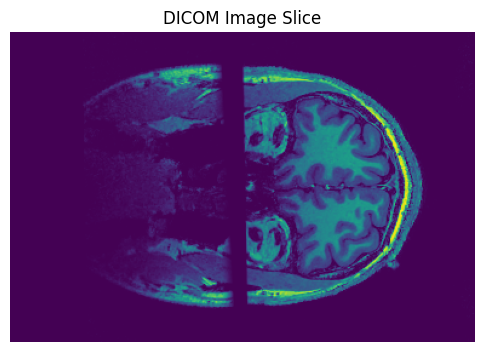

In [13]:
import pydicom
import os

# Path to one of your generated DICOM slices (from any plane folder)
sample_dicom_path = r'C:\Users\HP\Downloads\Sample data\dicom_output\coronal\coronal_slice_253.dcm'

# Read the DICOM file
ds = pydicom.dcmread(sample_dicom_path)

# Extract and display key metadata
print("📋 DICOM Metadata:")
print(f"Patient Name          : {ds.get('PatientName', 'N/A')}")
print(f"Patient ID            : {ds.get('PatientID', 'N/A')}")
print(f"Study Date            : {ds.get('StudyDate', 'N/A')}")
print(f"Modality              : {ds.get('Modality', 'N/A')}")
print(f"Pixel Spacing         : {ds.get('PixelSpacing', 'N/A')}")
print(f"Slice Thickness       : {ds.get('SliceThickness', 'N/A')}")
print(f"Image Position Patient: {ds.get('ImagePositionPatient', 'N/A')}")
print(f"Image Orientation     : {ds.get('ImageOrientationPatient', 'N/A')}")
print(f"Rows x Columns        : {ds.Rows} x {ds.Columns}")
plt.figure(figsize=(6,6))
plt.imshow(ds.pixel_array)
plt.title('DICOM Image Slice')
plt.axis('off')
plt.show()


In [14]:
import os
import pydicom
import numpy as np

def load_dicom_volume(dicom_dir):
    # Load all DICOM files in the directory
    dicom_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    slices = [pydicom.dcmread(f) for f in dicom_files]

    # Sort slices: Prefer ImagePositionPatient (z-axis), fallback to InstanceNumber
    try:
        slices.sort(key=lambda s: float(s.ImagePositionPatient[2]))
    except AttributeError:
        slices.sort(key=lambda s: int(s.InstanceNumber))

    # Stack into a 3D volume (Slices, Rows, Columns)
    pixel_arrays = [s.pixel_array for s in slices]
    volume = np.stack(pixel_arrays, axis=0)

    # Transpose to (Rows, Columns, Slices) if needed
    volume_transposed = np.transpose(volume, (1, 2, 0))  # from (D, H, W) to (H, W, D)

    print(f"✅ Loaded DICOM volume from {dicom_dir}")
    print(f"📏 Volume shape: {volume_transposed.shape} (Rows, Columns, Slices)")

    return volume_transposed


In [15]:
# Paths to your DICOM directories
axial_dir = "dicom_output/axial"
coronal_dir = "dicom_output/coronal"
sagittal_dir = "dicom_output/sagittal"

# Load and stack volumes
axial_volume = load_dicom_volume(axial_dir)
coronal_volume = load_dicom_volume(coronal_dir)
sagittal_volume = load_dicom_volume(sagittal_dir)


✅ Loaded DICOM volume from dicom_output/axial
📏 Volume shape: (256, 362, 384) (Rows, Columns, Slices)
✅ Loaded DICOM volume from dicom_output/coronal
📏 Volume shape: (256, 384, 362) (Rows, Columns, Slices)
✅ Loaded DICOM volume from dicom_output/sagittal
📏 Volume shape: (362, 384, 256) (Rows, Columns, Slices)


In [16]:
import matplotlib.pyplot as plt

def plot_anatomical_planes(volume):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial: slices along z-axis
    axial_slice = volume[:, :, volume.shape[2] // 2]
    axes[0].imshow(axial_slice.T,  origin='lower')
    axes[0].set_title('Axial View (Top-Down)')
    
    # Coronal: slices along y-axis
    coronal_slice = volume[:, volume.shape[1] // 2, :]
    axes[1].imshow(coronal_slice.T, origin='lower')
    axes[1].set_title('Coronal View (Front-Back)')
    
    # Sagittal: slices along x-axis
    sagittal_slice = volume[volume.shape[0] // 2, :, :]
    axes[2].imshow(sagittal_slice.T, origin='lower')
    axes[2].set_title('Sagittal View (Side-to-Side)')

    for ax in axes:
        ax.axis('off')

    plt.show()



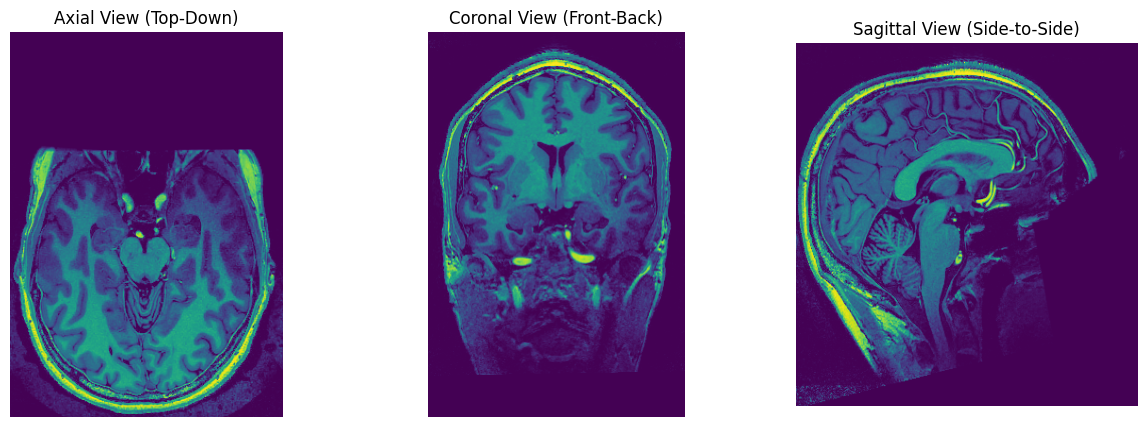

In [17]:
plot_anatomical_planes(axial_volume)


In [18]:
!pip install -q ipywidgets
!pip install -q Ipython

In [41]:
import ipywidgets as widgets
from IPython.display import display

def interactive_view(volume, title="Volume"):
    def plot_slices(axial_idx, coronal_idx, sagittal_idx):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(np.rot90(volume[:, :, axial_idx]))
        axes[0].set_title(f"{title} Axial (Z={axial_idx})")
        axes[0].axis('off')

        axes[1].imshow(np.rot90(volume[:, coronal_idx, :]))
        axes[1].set_title(f"{title} Coronal (Y={coronal_idx})")
        axes[1].axis('off')

        axes[2].imshow(np.rot90(volume[sagittal_idx, :, :]))
        axes[2].set_title(f"{title} Sagittal (X={sagittal_idx})")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    display(widgets.interactive(
        plot_slices,
        axial_idx=widgets.IntSlider(min=0, max=volume.shape[2]-1, step=1, value=volume.shape[2]//2),
        coronal_idx=widgets.IntSlider(min=0, max=volume.shape[1]-1, step=1, value=volume.shape[1]//2),
        sagittal_idx=widgets.IntSlider(min=0, max=volume.shape[0]-1, step=1, value=volume.shape[0]//2),
    ))

In [ ]:
interactive_view(axial_volume, title="DICOM Axial")

interactive(children=(IntSlider(value=192, description='axial_idx', max=383), IntSlider(value=181, description…